# __Implementing CNN (Convulusion Neural Network) from scratch__
### without machine learning library and with numpy and pandas only


##### imports

In [1]:
# import library 
import os 
import numpy as np 
import struct 
import gzip
import matplotlib.pyplot as plt

##### const variable

In [2]:
# const
DATASET_TYPE = "byclass"
RAW_DIR      = "gzip/"
UNPACK_DIR   = f"unpacked_{DATASET_TYPE}"
NPY_DIR      = "datasets_npy"

##### Reading, Storing data


In [3]:

def read_idx(file_name):
    with open(file_name, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        data = np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)
    return data

def load_emnist_byclass(path=UNPACK_DIR, dataset_type = DATASET_TYPE):
    if os.path.exists(path):
        return  

    # files are inside gzip.zip -> extract first
    X_train = read_idx(os.path.join(path, f"emnist-{dataset_type}-train-images-idx3-ubyte")) 
    y_train = read_idx(os.path.join(path, f"emnist-{dataset_type}-train-labels-idx1-ubyte")) 
    X_test  = read_idx(os.path.join(path, f"emnist-{dataset_type}-test-images-idx3-ubyte")) 
    y_test  = read_idx(os.path.join(path, f"emnist-{dataset_type}-test-labels-idx1-ubyte")) 
    
    save_binary(X_train, y_train, X_test, y_test)

def save_binary(X_train, y_train, X_test, y_test, path=NPY_DIR):
    if os.path.exists(path):
        return 
    
    # create folder 
    os.makedirs(path)

    # save ubyte to binary format 
    np.save(os.path.join(path, "X_train.npy"), X_train.astype("float32") / 255)
    np.save(os.path.join(path, "Y_train.npy"), y_train.astype("float32") / 255)
    np.save(os.path.join(path, "X_test.npy"), X_test.astype("float32") / 255)
    np.save(os.path.join(path, "Y_test.npy"), y_test.astype("float32") / 255)


# Define the directory where your files are located
def extract_gzip(input_dir = RAW_DIR, data_set_type=DATASET_TYPE):
    """"""
    unpacked_dir =  f"unpacked_{data_set_type}"
    # TODO: since uncompressed files are at the same heirarchy as the ain code file find a way for git 
    #       ignore to to be able to ignore other data set type folder

    if os.path.exists(unpacked_dir):
        print("Checking:", os.path.abspath(unpacked_dir))
        print("gzip directory already exist")
        return 

    # if directory does not exist 
    print("making directory")
    os.makedirs(unpacked_dir)    

    # Loop through all files in the specified directory
    # example relative path "gzip\emnist-digits-test-images-idx3-ubyte.gz"
    for filename in os.listdir(input_dir):
        # split the file name for data set type checking 
        name = filename.split("-")

        # Check if the file has a '.gz' extension
        if (filename.endswith('.gz')) and name[1] == data_set_type:
            # Construct the full path for the compressed file
            compressed_filepath = os.path.join(input_dir, filename)

            # Create the name for the new uncompressed file by removing the '.gz' extension
            uncompressed_filename = os.path.splitext(filename)[0]
            uncompressed_filepath = os.path.join(unpacked_dir, uncompressed_filename)

            # Open the compressed file and the new uncompressed file
            with gzip.open(compressed_filepath, 'rb') as f_in:
                with open(uncompressed_filepath, 'wb') as f_out:
                    f_out.write(f_in.read())

            print(f'\t- Extracted: {filename} -> {uncompressed_filename}')

extract_gzip()
load_emnist_byclass()

Checking: c:\Users\acer\Desktop\PROGRAMMING\machine_learning\NumPy-CNN-Handwritten-Digit-Recognition-from-Scratch\unpacked_byclass
gzip directory already exist


#### Helper

In [ ]:
def plot_sample(bitmap_sample):
    plt.imshow(bitmap_sample, cmap="gray")
    plt.show

#### CNN implementation


<function matplotlib.pyplot.show(close=None, block=None)>

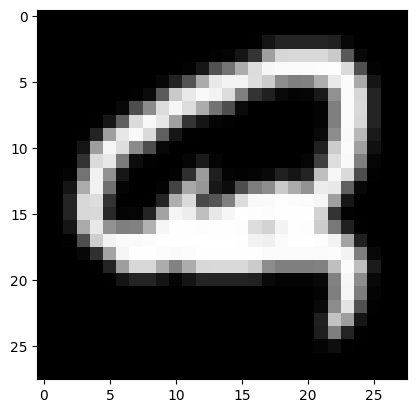

In [ ]:
xtrain = np.load("datasets_npy/X_train.npy", mmap_mode='r')
ytrain = np.load("datasets_npy/Y_train.npy", mmap_mode='r')
xtest = np.load("datasets_npy/X_test.npy", mmap_mode='r')
ytest = np.load("datasets_npy/Y_test.npy", mmap_mode='r')

class CNN():
    def __init__(self):
        pass
    def convolution(self):
        pass
    def max_pool(self):
        pass
    def flatten(self):
        pass 